<a href="https://colab.research.google.com/github/JP0512/CanField/blob/master/file/Copy_of_Copy_of_TumorClassification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
# Install necessary libraries 
!pip install segmentation-models
!pip install tensorflow ==2.1.0
!pip install keras ==2.3.1
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.0 MB/s 
ERROR: Invalid requirement: '==2.1.0'
ERROR: Invalid requirement: '==2.3.1'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 15.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import segmentation_models as sm
import tensorflow as tf
import seaborn as sns
import numpy as np
import requests
import pathlib
import glob
import PIL
import os

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
path = '/content/drive/My Drive/CanField'
os.chdir(path)

# Semantic Segmentation

In [ ]:
# Declares backbone and preprocessing input
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#Sets image parameters
batch_size = 30
img_height = 224
img_width = 224
IMG_WIDTH_HEIGHT = 224

## Loading and splitting data

In [ ]:
# Create arrays with image paths 
input_dir = 'data/Training_Input/pigment_network'
target_dir = 'data/Training_GroundTruth/pigment_network'

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [ ]:
# Preprocess the arrays with specificc parameters
from keras.preprocessing.image import load_img, array_to_img, img_to_array

X = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 3), dtype=np.float32)
Y = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)
for i in range(len(target_img_paths)):
    img_path = input_img_paths[i]
    img = load_img(img_path, color_mode='rgb',target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    img = img_to_array(img)
    X[i] = img.astype('float32')
    
    mask_path = target_img_paths[i]
    mask = load_img(mask_path, color_mode = 'grayscale',target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT))
    mask = (img_to_array(mask)).astype("float32")
    Y[i] = mask

In [ ]:
# Splits into train and test
train_test_split = int(len(input_img_paths)*0.9)
x_train = X[:train_test_split]
y_train = Y[:train_test_split]
x_test = X[train_test_split:]
y_test = Y[train_test_split:]

In [ ]:
import albumentations as A
import cv2

AUGMENTER_TRAIN = A.Compose(
      transforms=[
          A.Resize(height=img_height, width=img_width, always_apply=True, p=1.0),
          # A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1.0),
          A.Transpose(p=0.5),
          A.VerticalFlip(p=0.5),
          A.HorizontalFlip(p=0.5),
      ],
  )

for i, j in enumerate(x_train):
  transformed = AUGMENTER_TRAIN(image=x_train[i], mask=y_train[i], keypoints=[])
  transformed_image = [transformed['image']]
  transformed_mask = [transformed['mask']]
  x_train = np.append(x_train, transformed_image, axis=0)
  y_train = np.append(y_train, transformed_mask, axis=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1370


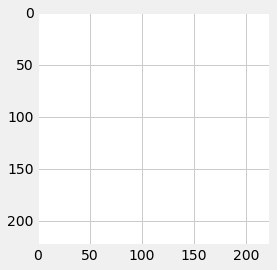

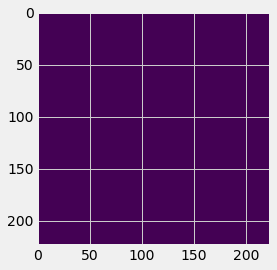

In [ ]:
# Displays random image with its mask
import random
i = random.randint(0, len(x_train))
print(i)
plt.imshow(x_train[i])
plt.show()
plt.imshow(np.squeeze(y_train[i]))
plt.show()

In [ ]:
# Changes train and test datatypes for training
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)

In [ ]:
# Preprocess train and test
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
y_train = preprocess_input(y_train)
y_test = preprocess_input(y_test)

## Creates and trains model


In [ ]:
# Sets framework to keras to avoid errors
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
# define model
model = []
model = sm.Unet(backbone_name=BACKBONE)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [ ]:
# Uses RSM as optimizer
RSM = tf.keras.optimizers.RMSprop(
                            learning_rate=0.000001,
                            rho=0.9,
                            momentum=0.0,
                            epsilon=1e-07,
                            centered=False,
                            name="RMSprop")

# Compile model
model.compile(loss=sm.losses.categorical_crossentropy,
               optimizer = RSM,
              metrics=[sm.metrics.iou_score])

In [ ]:
# Fits model to dataset
history=model.fit(x_train, 
          y_train,
          batch_size=batch_size, 
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
51/51 [==============================] - 19s 224ms/step - loss: -0.4817 - iou_score: 1.4817 - val_loss: -0.0510 - val_iou_score: 1.0612
Epoch 2/100
51/51 [==============================] - 11s 208ms/step - loss: -0.5796 - iou_score: 1.5783 - val_loss: -0.2659 - val_iou_score: 1.2750
Epoch 3/100
51/51 [==============================] - 10s 205ms/step - loss: -0.6818 - iou_score: 1.6824 - val_loss: -0.4633 - val_iou_score: 1.4679
Epoch 4/100
51/51 [==============================] - 10s 205ms/step - loss: -0.7665 - iou_score: 1.7634 - val_loss: -0.6278 - val_iou_score: 1.6303
Epoch 5/100
51/51 [==============================] - 10s 205ms/step - loss: -0.8829 - iou_score: 1.8807 - val_loss: -0.7871 - val_iou_score: 1.7881
Epoch 6/100
51/51 [==============================] - 11s 206ms/step - loss: -0.9815 - iou_score: 1.9807 - val_loss: -0.9314 - val_iou_score: 1.9315
Epoch 7/100
51/51 [==============================] - 10s 205ms/step - loss: -1.0976 - iou_score: 2.0959 - val_lo

In [ ]:
# Saves model locally
model.save('Unet_resnet34_13.h5')

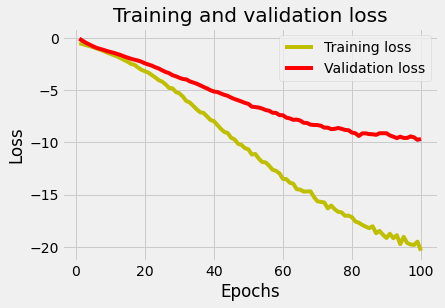

In [ ]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Loads model
model = tf.keras.models.load_model('Unet_resnet34_10.h5', compile = False)

In [ ]:
predictions = model.predict(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


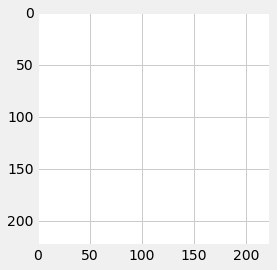

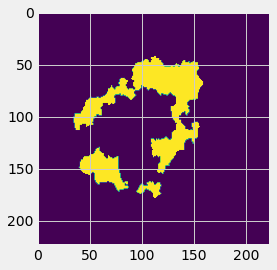

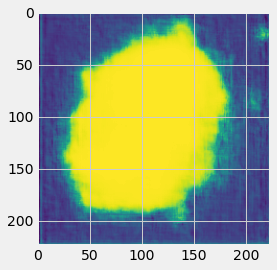

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


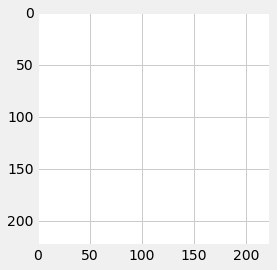

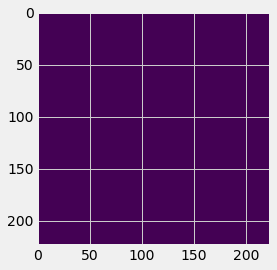

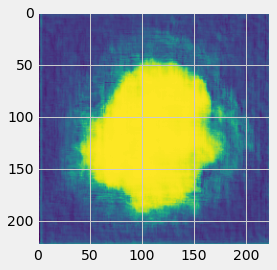

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


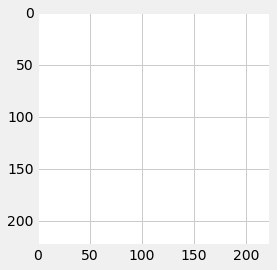

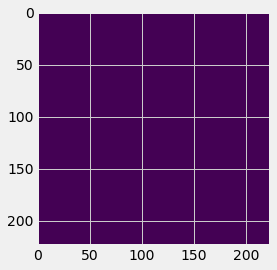

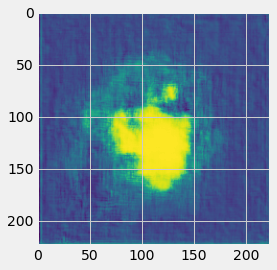

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


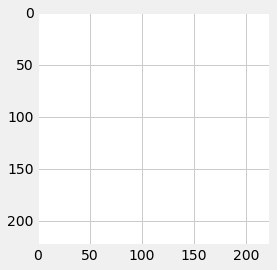

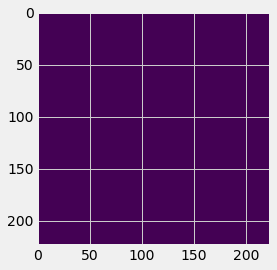

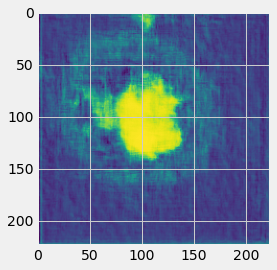

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


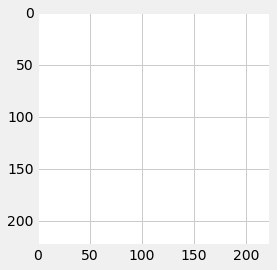

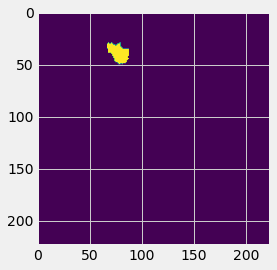

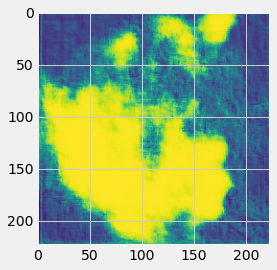

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


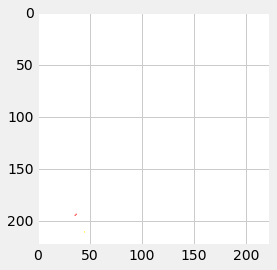

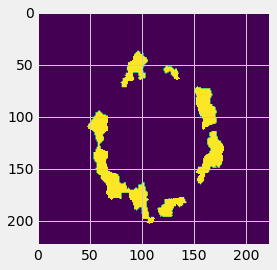

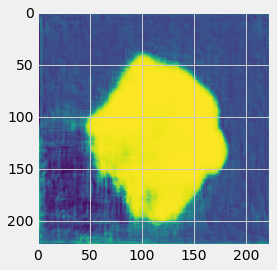

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


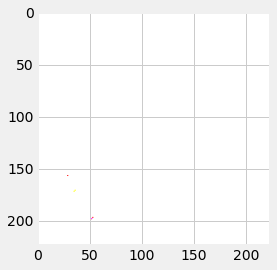

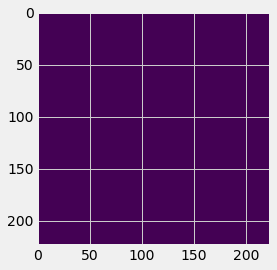

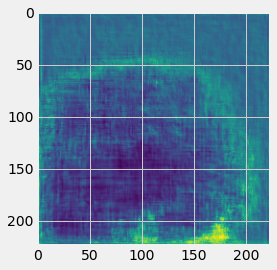

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


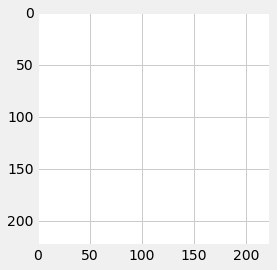

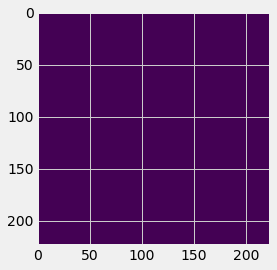

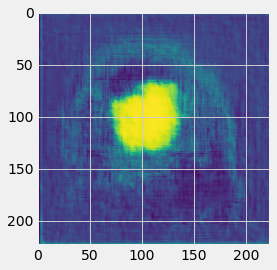

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


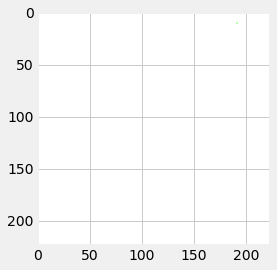

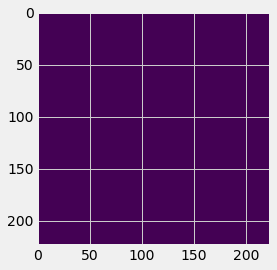

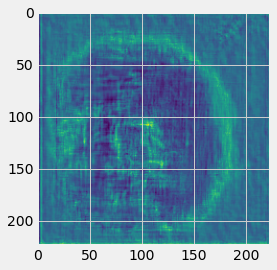

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


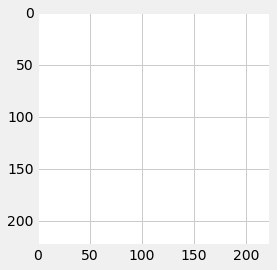

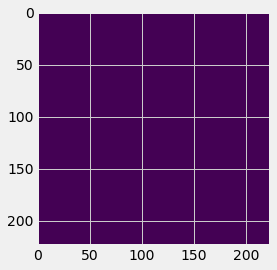

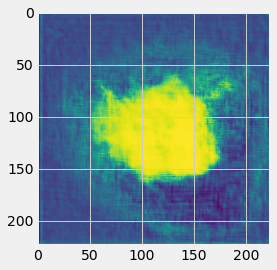

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


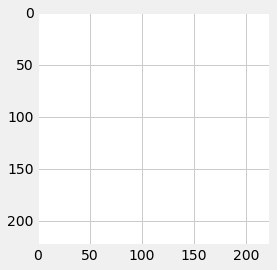

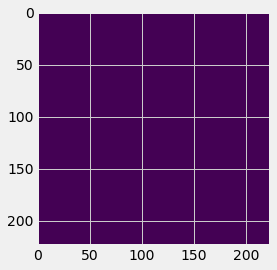

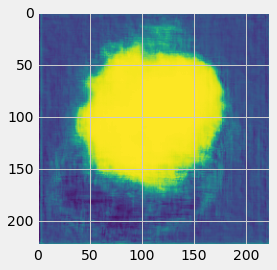

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


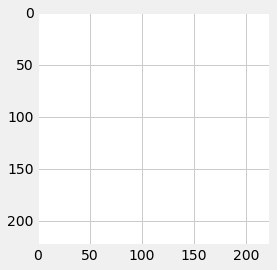

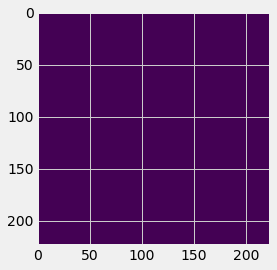

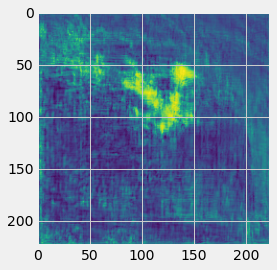

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


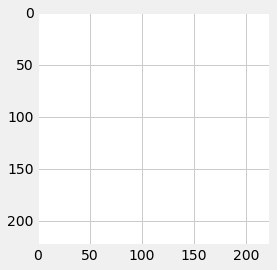

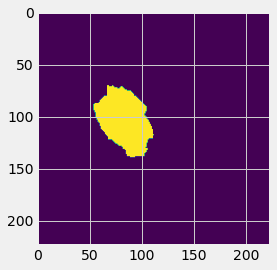

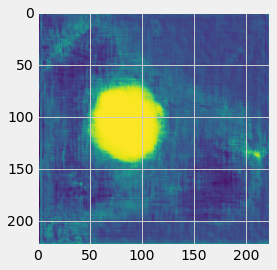

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


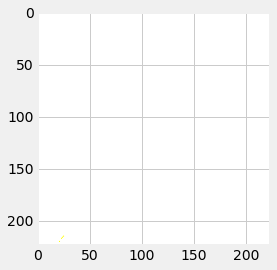

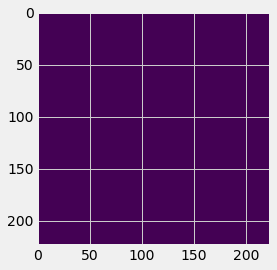

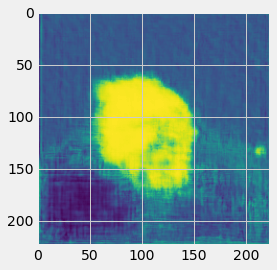

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


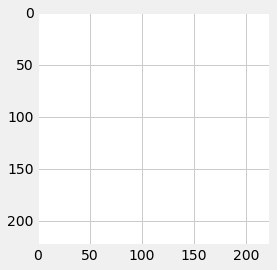

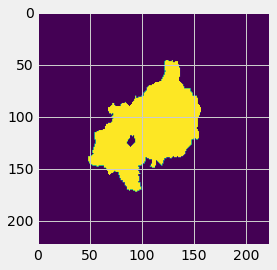

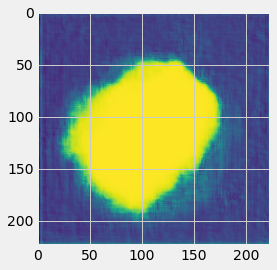

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


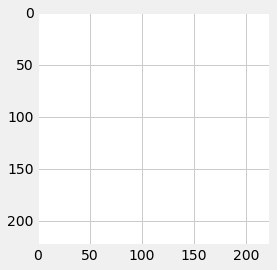

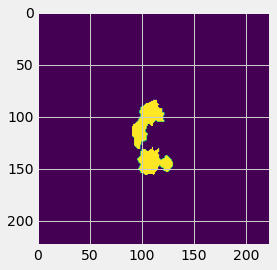

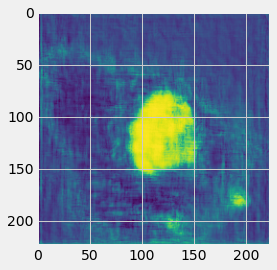

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


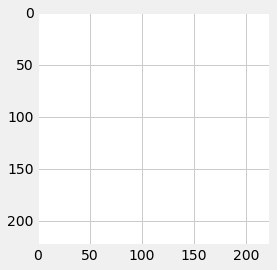

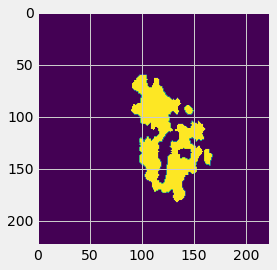

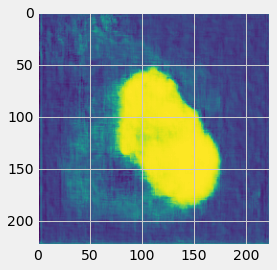

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


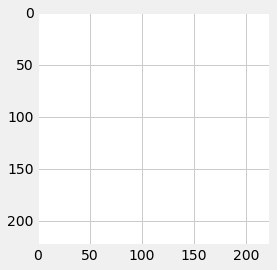

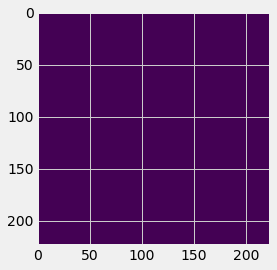

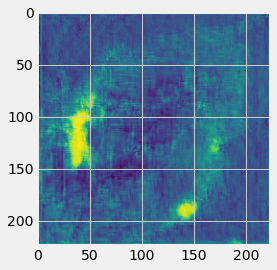

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


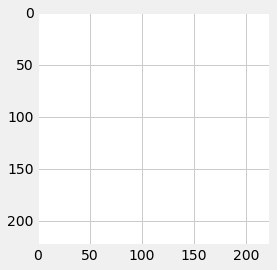

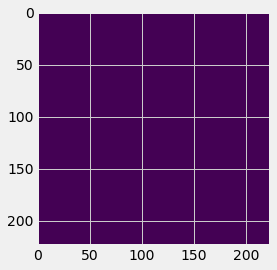

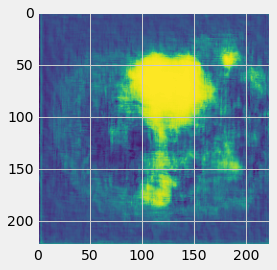

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


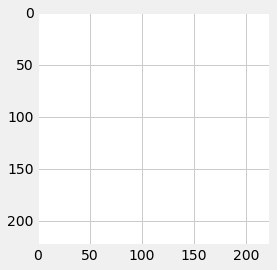

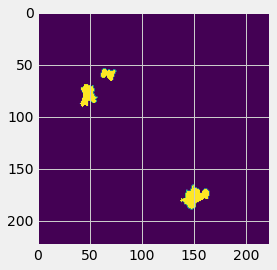

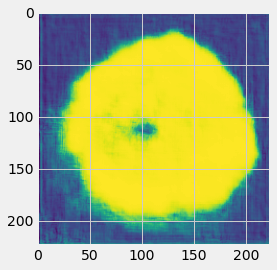

In [ ]:
#@title Default title text
# Displays images, masks and predictions 
for i in range(20):
  plt.imshow(x_test[i])
  plt.show()
  plt.imshow(np.squeeze(y_test[i]))
  plt.show()
  plt.imshow(np.squeeze(predictions[i]))
  plt.show()

## Evaluate convolutions

In [ ]:
# Loads model
model = tf.keras.models.load_model('Unet_resnet34.h5', compile = False)

In [ ]:
# Recompiles models
RSM = tf.keras.optimizers.RMSprop(
                            learning_rate=0.000005,
                            rho=0.9,
                            momentum=0.0,
                            epsilon=1e-07,
                            centered=False,
                            name="RMSprop")

model.compile(loss=sm.losses.bce_jaccard_loss,
               optimizer = RSM,
              metrics=[sm.metrics.iou_score])

In [ ]:
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=5

In [ ]:
#Let's vizualize what the CNN is doing with the images
f, axarr = plt.subplots(3,5, figsize=(12,6))

#Shows what each conv is doing
CONVOLUTION_NUMBER = 2

from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(1,4):
  f1 = activation_model.predict(x_test[FIRST_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='plasma')
  f2 = activation_model.predict(x_test[SECOND_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  f3 = activation_model.predict(x_test[THIRD_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='viridis')

axarr[0,0].imshow(x_test[FIRST_IMAGE])
axarr[1,0].imshow(x_test[SECOND_IMAGE])
axarr[2,0].imshow(x_test[THIRD_IMAGE])


axarr[0,4].imshow(np.squeeze(y_test[FIRST_IMAGE]))
axarr[1,4].imshow(np.squeeze(y_test[SECOND_IMAGE]))
axarr[2,4].imshow(np.squeeze(y_test[THIRD_IMAGE]))


for i in range(0, 3):
  for j in range(0, 5):
    axarr[i, j].grid(False)
    axarr[i ,j].axes.get_yaxis().set_visible(False)
    axarr[i ,j].axes.get_xaxis().set_visible(False)

plt.show()